In [1]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib
cmap = 'plasma'

from PIL import Image

In [2]:
from matplotlib.path import Path
def mask_rotated_rectangle(shape, center, width, length, angle_deg):
    """
    Returns a mask (2D bool array) for a rotated rectangle.
    
    Parameters:
    - shape: (rows, cols) of the image
    - center: (x, y) = center of one width-side of the rectangle
    - width: scalar width of the rectangle (short side)
    - length: scalar length of the rectangle (long side)
    - angle_deg: rotation angle (CCW from x-axis) in degrees
    """
    cx, cy = center
    angle_rad = np.deg2rad(angle_deg)

    # Direction vector along length
    dx = np.cos(angle_rad)
    dy = np.sin(angle_rad)

    # Half-length and half-width vectors
    hl = length / 2
    hw = width / 2

    # Midpoint of rectangle (center of rectangle)
    cx_mid = cx + hl * dx
    cy_mid = cy + hl * dy

    # Orthonormal basis (dx, dy) and perpendicular (-dy, dx)
    ux, uy = dx, dy
    vx, vy = -dy, dx

    # Define 4 corners (clockwise)
    corners = np.array([
        [cx_mid + hl*ux + hw*vx, cy_mid + hl*uy + hw*vy],
        [cx_mid + hl*ux - hw*vx, cy_mid + hl*uy - hw*vy],
        [cx_mid - hl*ux - hw*vx, cy_mid - hl*uy - hw*vy],
        [cx_mid - hl*ux + hw*vx, cy_mid - hl*uy + hw*vy],
    ])

    # Generate grid
    yy, xx = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    points = np.vstack((xx.ravel(), yy.ravel())).T

    # Check which pixels are inside polygon
    path = Path(corners)
    inside = path.contains_points(points)
    mask = inside.reshape(shape)
    return mask


## Load data

Data ID 0001 – Zero-value pixels in unmasked area: 97.28%
Data ID 0002 – Zero-value pixels in unmasked area: 93.31%
Data ID 0003 – Zero-value pixels in unmasked area: 85.08%
Data ID 0004 – Zero-value pixels in unmasked area: 74.12%
Data ID 0005 – Zero-value pixels in unmasked area: 62.48%
Data ID 0006 – Zero-value pixels in unmasked area: 54.60%
Data ID 0007 – Zero-value pixels in unmasked area: 48.72%
Data ID 0008 – Zero-value pixels in unmasked area: 45.09%
Data ID 0009 – Zero-value pixels in unmasked area: 42.62%
Data ID 0010 – Zero-value pixels in unmasked area: 39.11%
Data ID 0011 – Zero-value pixels in unmasked area: 24.84%


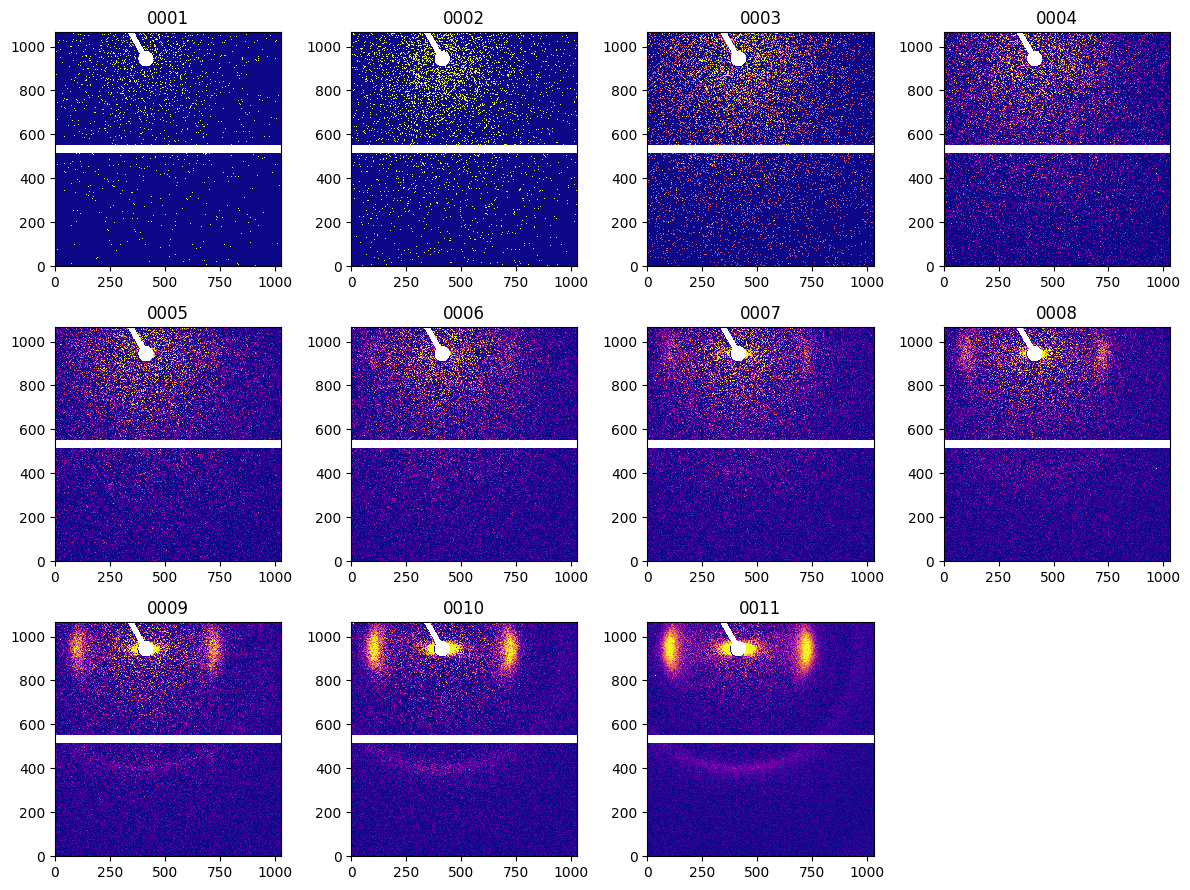

In [3]:
## load data
filepath = './data/NSRRC'
list_data_id = np.linspace(1, 11, 11, dtype=int)

fig, ax = plt.subplots(3, 4, figsize=(12, 9))
ax = ax.flatten()

beam_center = [414.070,944.693]
disk_radius = 35          # <<< radius of the masked beam centre in pixels
cx, cy = beam_center      # beam_center = [row (y), col (x)]

# rectangle parameters
rect_width = 25       # in pixels
rect_length = 400     # in pixels
rect_angle = 120       # degrees CCW from x-axis

list_zeros = []
for i_id, data_id in enumerate(list_data_id):
    filename = f"{filepath}/{data_id:04d}.tif"
    image    = Image.open(filename)
    data     = np.array(image)

    mask_neg = data < 0                   # original negative-value mask

    # Create masks
    yy, xx = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]), indexing='ij')
    
    # Disk mask
    cx, cy = beam_center
    mask_disk = (xx - cx)**2 + (yy - cy)**2 <= disk_radius**2

    # Rectangle mask
    mask_rect = mask_rotated_rectangle(data.shape, beam_center, rect_width, rect_length, rect_angle)

    # Combine all masks
    mask = mask_neg | mask_disk | mask_rect
    # -------------------------------------------

    filename_b = f"{filepath}/{data_id:04d}B.tif"
    data_b     = np.array(Image.open(filename_b))

    data_plot  = data - data_b
    data_plot  = np.clip(data_plot, 0, None)           # forbid negatives
    data_plot  = np.ma.masked_where(mask, data_plot)   # transparent where masked
    
    # Count total unmasked pixels
    n_unmasked = np.count_nonzero(~data_plot.mask)

    # Count unmasked pixels with value exactly zero
    n_zero = np.count_nonzero((~data_plot.mask) & (data_plot.data == 0))

    # Compute and print percentage
    percent_zero = (n_zero / n_unmasked) * 100 if n_unmasked else 0
    print(f"Data ID {data_id:04d} – Zero-value pixels in unmasked area: {percent_zero:.2f}%")
    list_zeros.append(percent_zero)

    n_pixels   = data.shape[0] * data.shape[1]
    n_counts   = data_plot.sum()                       # respects mask
    cpp        = n_counts / n_pixels if n_pixels else 0

    x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))

    axi = ax[i_id]
    axi.pcolormesh(x, y, data_plot,
                   cmap=cmap,
                   vmin=0,
                   vmax=cpp * 10,
                   shading='auto')
    axi.set_title(f"{data_id:04d}")
    # axi.axis('off')
    axi.set_aspect('equal')

# hide last empty subplot
ax[-1].axis('off')
plt.tight_layout()


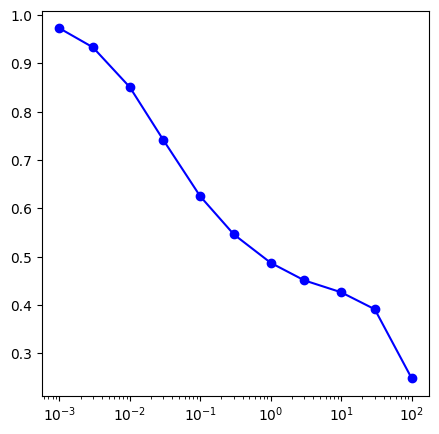

In [4]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

list_time = [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1, 3, 10, 30, 100]

ax.plot(list_time, np.array(list_zeros)/100, marker='o', linestyle='-', color='b')
ax.set_xscale('log')
# ax.set_yscale('log')

## Rebinning

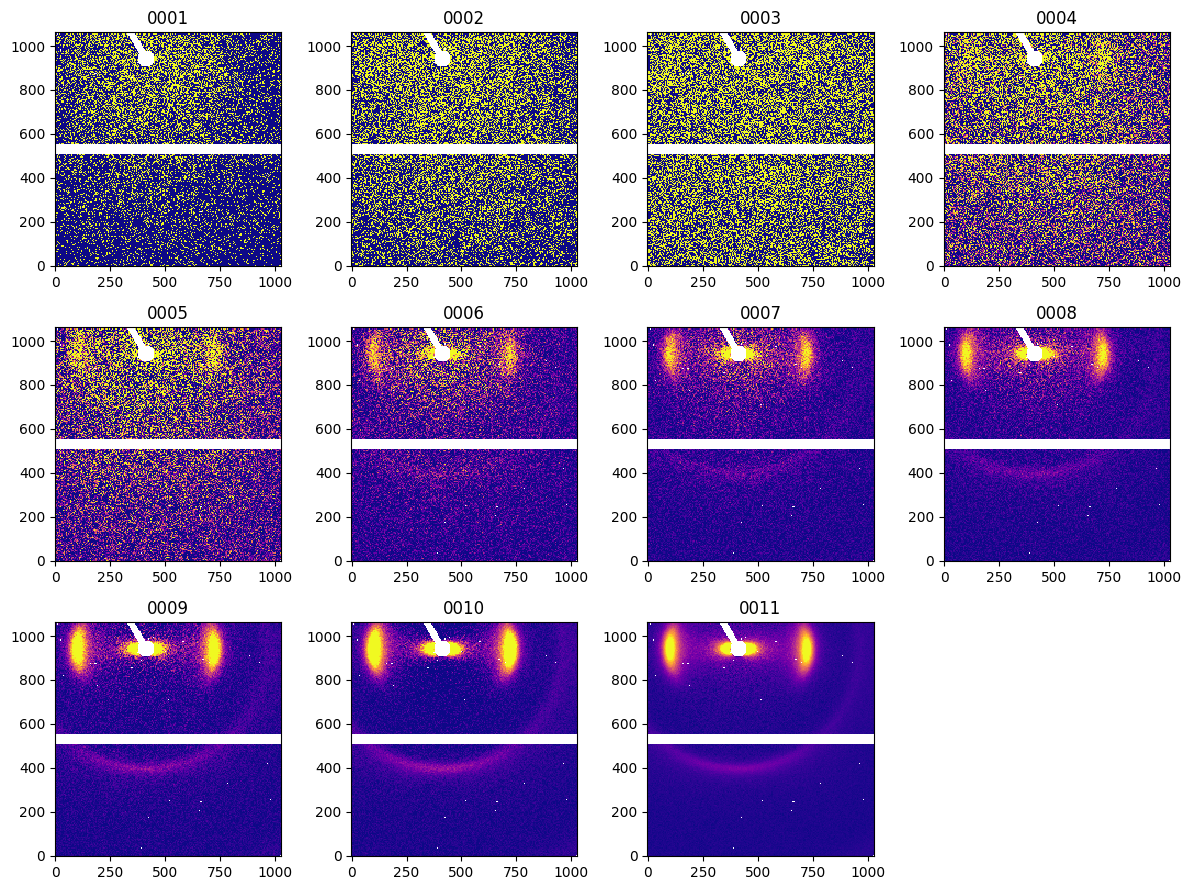

In [5]:
def rebin_with_mask(data, mask, n):
    """
    Rebins the input 2D array `data` and mask by a factor `n` using mean over non-masked pixels.
    If any pixel in a block is masked, the entire rebinned pixel is masked.
    """
    M, N = data.shape
    M_new, N_new = M // n, N // n

    # Trim to multiple of n
    data = data[:M_new * n, :N_new * n]
    mask = mask[:M_new * n, :N_new * n]

    # Reshape to blocks of n x n
    data_blocks = data.reshape(M_new, n, N_new, n).transpose(0, 2, 1, 3)
    mask_blocks = mask.reshape(M_new, n, N_new, n).transpose(0, 2, 1, 3)

    # New mask: True if any pixel in block is masked
    mask_rebinned = mask_blocks.any(axis=(2, 3))

    # Compute mean only where not masked
    data_masked = np.ma.masked_array(data_blocks, mask_blocks)
    data_rebinned = data_masked.mean(axis=(2, 3))

    # Apply propagated mask
    data_rebinned = np.ma.masked_where(mask_rebinned, data_rebinned)

    return data_rebinned

# Plotting with rebinning
fig, ax = plt.subplots(3, 4, figsize=(12, 9))
ax = ax.flatten()

n = 5  # Rebinning factor

data_rebin_list = []
for i_id, data_id in enumerate(list_data_id):
    filename = f"{filepath}/{data_id:04d}.tif"
    image = Image.open(filename)
    data = np.array(image)

    mask_neg = data < 0                   # original negative-value mask

    # Create masks
    yy, xx = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]), indexing='ij')
    
    # Disk mask
    cx, cy = beam_center
    mask_disk = (xx - cx)**2 + (yy - cy)**2 <= disk_radius**2

    # Rectangle mask
    mask_rect = mask_rotated_rectangle(data.shape, beam_center, rect_width, rect_length, rect_angle)

    # Combine all masks
    mask = mask_neg | mask_disk | mask_rect
    # -------------------------------------------

    filename_b = f"{filepath}/{data_id:04d}B.tif"
    image_b = Image.open(filename_b)
    data_b = np.array(image_b)

    data_plot = data - data_b

    # Apply mask
    data_masked = np.ma.masked_where(mask, data_plot)

    # Rebin data and mask together
    data_rebinned = rebin_with_mask(data_masked, mask, n)

    n_pixels = data_rebinned.count()  # Number of valid (non-masked) pixels
    n_counts = data_rebinned.sum()
    cpp = n_counts / n_pixels if n_pixels > 0 else 0

    # Create coordinates for rebinned data
    M_new, N_new = data_rebinned.shape
    x, y = np.meshgrid(np.arange(N_new) * n, np.arange(M_new) * n)

    axi = ax[i_id]
    axi.pcolormesh(
        x, y, data_rebinned,
        cmap=cmap,
        vmin=0,
        vmax=cpp * 10,
        shading='auto'
    )
    axi.set_title(f"{data_id:04d}")
    # axi.axis('off')
    axi.set_aspect('equal')
    data_rebin_list.append(data_rebinned)

# Hide unused subplot
ax[-1].axis('off')
plt.tight_layout()


In [6]:
## Identification of principal axis 
def f_pl_obs(qx_obs, qy_obs, I_obs):
    qxqx = np.sum(I_obs * qx_obs * qx_obs)
    qxqy = np.sum(I_obs * qx_obs * qy_obs)
    qyqy = np.sum(I_obs * qy_obs * qy_obs)
    R = [[qxqx, qxqy], [qxqy, qyqy]]
    eigenvalues, eigenvectors = np.linalg.eig(R)
    principal_axis = eigenvectors[:, np.argmax(eigenvalues)]
    pl_eigen = np.arctan2(principal_axis[1], principal_axis[0])
    return pl_eigen

def f_C(theta, n, theta_0=0, bg=True):
    """
    Construct a symmetric cosine basis matrix evaluated at given angles.

    Parameters:
    - theta: array-like, angles where basis is evaluated (in radians)
    - n: number of non-constant cosine modes (n > 0)
    - theta_0: alignment angle for symmetry shift
    - bg: if True, include constant (isotropic) term in first column

    Returns:
    - C: (len(theta), n+1) array if bg=True, else (len(theta), n) array
    """
    theta = np.asarray(theta)
    theta_shift = theta - theta_0
    n_list = 2 * (np.arange(n) + 1)  # modes: 2, 4, ..., 2n

    C_cos = np.cos(np.outer(theta_shift, n_list))  # shape (M, n)

    if bg:
        C_0 = np.ones((len(theta), 1))  # constant term
        C = np.concatenate([C_0, C_cos], axis=1)  # (M, n+1)
    else:
        C = C_cos  # (M, n)

    return C

def f_CS(theta, n, theta_0=0, bg=True):
    """
    Construct a real-valued Fourier basis with symmetric cosine and sine terms.

    Parameters:
    - theta: array-like, input angles in radians
    - n: number of cosine/sine harmonics (positive integers)
    - theta_0: alignment angle (shifts all basis functions)
    - bg: if True, include constant term as first column

    Returns:
    - C: (len(theta), 2n+1) if bg=True, else (len(theta), 2n)
         Columns ordered as [1, cos(2θ), ..., cos(2nθ), sin(2θ), ..., sin(2nθ)]
    """
    theta = np.asarray(theta)
    theta_shift = theta - theta_0
    n_list = 2 * (np.arange(1, n + 1))  # modes: 2, 4, ..., 2n

    C_cos = np.cos(np.outer(theta_shift, n_list))  # (M, n)
    C_sin = np.sin(np.outer(theta_shift, n_list))  # (M, n)

    if bg:
        C_0 = np.ones((len(theta), 1))
        C = np.concatenate([C_0, C_cos, C_sin], axis=1)  # (M, 2n+1)
    else:
        C = np.concatenate([C_cos, C_sin], axis=1)       # (M, 2n)

    return C

def f_loglin(x, x_c=1):
    return np.where(x < x_c, (x-x_c)/x_c+np.log(x_c), np.log(x))
def f_loglin_inv(y, y_c=0):
    return np.where(y < y_c, (1+y-y_c)*np.exp(y_c), np.exp(y))

def bayesian_inference_ratio(I_obs, delta_I_obs, Q_obs, theta_obs, delta_Q, Q_eval, C_basis, mu_, lambda_,
                              mode="forward", log_transform=False):
    """
    Perform Bayesian inference on the modulation I(Q, theta) / I_radial(Q).

    Parameters:
    - log_transform: if True, calculate the radial average on log I

    Returns:
    - A_MAP: MAP estimate of the harmonic coefficients (L x N)
    - I_radial_eval: estimated radial profile I_radial(Q_eval)
    """
    L = len(Q_eval)
    M = len(Q_obs)
    N = C_basis.shape[1]

    print(f"L (Q_eval): {L}, M (obs): {M}, N (basis): {N}")
    
    if log_transform:
        x_c = np.mean(I_obs)
        y_c = np.log(x_c)

        f_I = lambda I: f_loglin(I, x_c)
        f_inv_I = lambda fI: f_loglin_inv(fI, y_c)

        # --- Radial background estimation in transformed space ---
        fI_obs = f_I(I_obs)
        K_Qobs_to_Qeval = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
        W_Qeval_from_Qobs = K_Qobs_to_Qeval / K_Qobs_to_Qeval.sum(axis=0, keepdims=True)
        fI_radial_eval = W_Qeval_from_Qobs.T @ fI_obs  # shape (L,)
        I_radial_eval = f_inv_I(fI_radial_eval)

        # --- Project radial profile back to observations ---
        K_Qobs_from_Qeval = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
        W_Qobs_from_Qeval = K_Qobs_from_Qeval / K_Qobs_from_Qeval.sum(axis=1, keepdims=True)
        fI_radial_obs = W_Qobs_from_Qeval @ fI_radial_eval  # shape (M,)
        I_radial_obs = f_inv_I(fI_radial_obs)
    else:
        # --- Radial background estimation ---
        K_Qobs_to_Qeval = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
        W_Qeval_from_Qobs = K_Qobs_to_Qeval / K_Qobs_to_Qeval.sum(axis=0, keepdims=True)
        I_radial_eval = W_Qeval_from_Qobs.T @ I_obs  # shape (L,)

        # --- Project radial profile back to observations ---
        K_Qobs_from_Qeval = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
        W_Qobs_from_Qeval = K_Qobs_from_Qeval / K_Qobs_from_Qeval.sum(axis=1, keepdims=True)
        I_radial_obs = W_Qobs_from_Qeval @ I_radial_eval  # shape (M,)
    

    # --- Normalize observations ---
    I_mod = I_obs / I_radial_obs
    delta_I_mod = delta_I_obs / I_radial_obs

    # --- Construct design matrix (M x LN) ---
    G = (K_Qobs_to_Qeval[:, :, None] * C_basis[:, None, :]).reshape(M, L * N)

    # --- Prior covariance ---
    Q_diff_sq = (Q_eval[:, None] - Q_eval[None, :]) ** 2
    K_spatial = np.exp(-Q_diff_sq / (2 * lambda_ ** 2))
    K_spatial_full = np.kron(np.eye(N), K_spatial)

    angular_penalty = np.array([0] + [(2*n) for n in range(1, N)])
    K_angular = np.kron(np.diag(angular_penalty), np.eye(L))
    K_prior = K_spatial_full + K_angular

    # --- Prior mean ---
    A_prior_mean = np.zeros((L, N))
    A_prior_mean[:, 0] = 1.0 
    A_prior_flat = A_prior_mean.flatten()

    # --- Observation noise covariance ---
    Sigma = np.diag(delta_I_mod**2)

    # --- MAP Inference ---
    if mode == "forward":
        Sigma_inv = np.diag(1.0 / delta_I_mod**2)
        GT_Sinv = G.T @ Sigma_inv
        K_tilde_inv = GT_Sinv @ G + np.linalg.inv(K_prior) 
        K_tilde_inv = K_tilde_inv + 1e-6 * np.eye(K_tilde_inv.shape[0])
        rhs = GT_Sinv @ (I_mod - G @ A_prior_flat)
        # A_post_flat = A_prior_flat + cho_solve(cho_factor(K_tilde_inv), rhs)
        try:
            A_post_flat = A_prior_flat + cho_solve(cho_factor(K_tilde_inv), rhs)
        except np.linalg.LinAlgError:
            print("Cholesky failed, falling back to np.linalg.solve")
            A_post_flat = A_prior_flat + np.linalg.solve(K_tilde_inv, rhs)
        
    elif mode == "dual":
        residual = I_mod - G @ A_prior_flat
        G_K = G @ K_prior
        K_tilde = G_K @ G.T + Sigma
        A_post_flat = A_prior_flat + K_prior @ G.T @ cho_solve(cho_factor(K_tilde), residual)
    else:
        raise ValueError("mode must be 'forward' or 'dual'")

    A_MAP = A_post_flat.reshape(L, N)
    return A_MAP, I_radial_eval

def reconstruct_I_q(Q_eval, theta_eval, A_MAP, f_basis, mu_, theta_0=0.0,
                    direct=False, bg=True, I_radial_eval=None, log_transform=False):
    """
    Reconstruct the intensity modulation I(Q, theta)/I_radial(Q) or log-form.

    Parameters:
    - log_transform: If True, A_MAP represents log(I / I_radial)

    Returns:
    - I_modulated: shape (K, L), modulation (I / I_radial) or exp(log modulation)
    """
    L, N = A_MAP.shape
    K = len(theta_eval)

    # Angular basis matrix (K, N)
    C_arr = f_basis(theta_eval, N - 1 if bg else N, theta_0=theta_0, bg=bg)

    if direct:
        I_modulated = C_arr @ A_MAP.T  # (K, L)
    else:
        spatial_kernel_eval = np.exp(-((Q_eval[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))  # (L, L)
        I_modulated = (spatial_kernel_eval @ A_MAP) @ C_arr.T  # (L, K)
        I_modulated = I_modulated.T  # shape (K, L)

    # Restore full I(Q, theta) if bg was removed
    if not bg:
        if I_radial_eval is None:
            raise ValueError("Must provide I_radial_eval if bg=False")
        I_modulated *= I_radial_eval[None, :]  # elementwise multiply

    return I_modulated

def reconstruct_I_q_ratio(Q_eval, theta_eval, A_MAP, f_basis, mu_, I_radial_eval,
                          theta_0=0.0, direct=False, log_transform=False):
    """
    Reconstruct full I(Q, theta) from inferred modulation coefficients and radial profile.

    Parameters:
    - log_transform: If True, treat A_MAP as log(I/I_radial)

    Returns:
    - I_full: (K, L) reconstructed intensity I(Q, theta)
    - I_mod:  (K, L) modulation (I/I_radial) or exp(log modulation)
    """
    I_mod = reconstruct_I_q(
        Q_eval, theta_eval, A_MAP, f_basis, mu_,
        theta_0=theta_0, direct=direct, bg=True,
        I_radial_eval=None, log_transform=log_transform
    )

    I_full = I_mod * I_radial_eval[None, :]  # restore I(Q, theta)
    return I_full, I_mod


## Prepare I_obs

In [7]:
data_rebinned = data_rebin_list[7]  # Select one rebinned dataset for analysis

# Unpack as regular arrays to avoid masked-array inheritance
x_flat = np.asarray(x.ravel())
y_flat = np.asarray(y.ravel())
I_flat = np.asarray(data_rebinned.data.ravel())  # use .data to strip mask
mask_flat = np.asarray(data_rebinned.mask.ravel()) if np.ma.is_masked(data_rebinned) else np.zeros_like(I_flat, dtype=bool)

# Beam center
cx, cy = beam_center

# Compute Q and theta in rebinned coordinate system
Qx = x_flat - cx
Qy = y_flat - cy
Q_obs_all = np.sqrt(Qx**2 + Qy**2)
theta_obs_all = np.arctan2(Qy, Qx)

# Apply full mask as boolean condition
valid = (~mask_flat) & (I_flat >= 0) & (Q_obs_all > 40) & (Q_obs_all < 540)

# Final filtered arrays (force regular ndarray)
Q_obs = np.asarray(Q_obs_all[valid])
theta_obs = np.asarray(theta_obs_all[valid])
I_obs = np.asarray(I_flat[valid])
delta_I_obs = np.sqrt(I_obs)
delta_I_obs[delta_I_obs == 0] = 1.0
ratio_blank = np.sum(I_obs == 0) / len(I_obs)
print(ratio_blank)

Q_obs_ext = np.concatenate([Q_obs, Q_obs])
theta_obs_ext = np.concatenate([theta_obs, theta_obs + np.pi])
I_obs_ext = np.concatenate([I_obs, I_obs])
delta_I_obs_ext = np.concatenate([delta_I_obs, delta_I_obs])

# Convert polar to Cartesian (observed data points)
Qx_obs = Q_obs_ext * np.cos(theta_obs_ext)
Qy_obs = Q_obs_ext * np.sin(theta_obs_ext)

# Define target location in (theta, Q) space
theta_target = 0.0
Q_target = 300.0

# Compute angular distance properly (wraparound at ±π)
dtheta = np.angle(np.exp(1j * (theta_obs - theta_target)))  # shortest signed angular difference
dQ = Q_obs - Q_target

# Euclidean distance in (theta, Q) space
distance = np.sqrt((dtheta)**2 + (dQ)**2)

# Get indices of 10 closest points
idx_closest = np.argsort(distance)[:15]

# Extract and average intensities
I_ref_obs = np.mean(I_obs[idx_closest])

# Wrap angles to [-π, π] if desired
theta_obs_ext = (theta_obs_ext + np.pi) % (2 * np.pi) - np.pi


0.004719086792934124


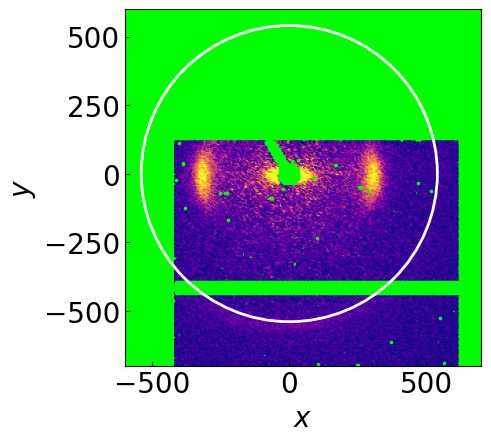

In [8]:
# Plot observed data in (Qx, Qy) space
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

sc = ax.scatter(x_flat[I_flat>0]- cx, y_flat[I_flat>0]- cy, c=I_flat[I_flat>0], s=2.5, alpha=1, cmap=cmap, vmin = 0, vmax = I_ref_obs*2)
# Plot masked data points in green
ax.scatter(x_flat[mask_flat] - cx, y_flat[mask_flat] - cy, c='#00FF00', s=2.5, alpha=1)
circle = plt.Circle((cx- cx, cy- cy), 540, color='w', fill=False, linewidth=2)
ax.add_artist(circle)

ax.set_xlim(-600,700)
ax.set_ylim(-700,600)
ax.set_xlabel(r'$x$', fontsize=20)
ax.set_ylabel(r'$y$', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.set_aspect('equal')
ax.set_facecolor('#00FF00')
plt.tight_layout()
plt.show()



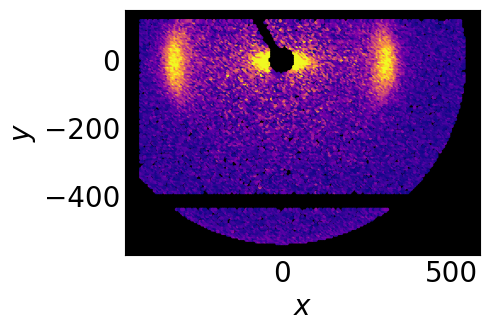

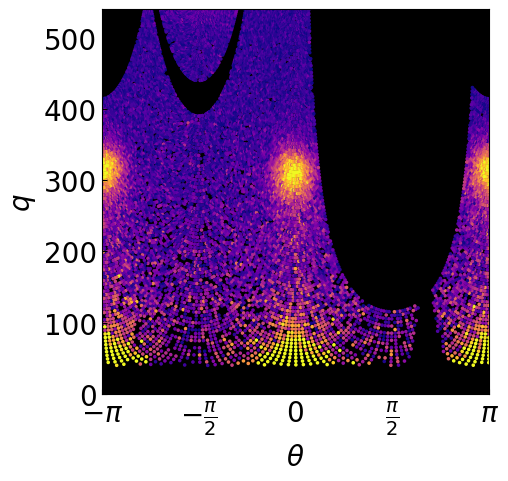

In [9]:
# Convert polar to Cartesian (observed data points)
Qx_obs = Q_obs * np.cos(theta_obs)
Qy_obs = Q_obs * np.sin(theta_obs)

# Plot observed data in (Qx, Qy) space
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

sc = ax.scatter(Qx_obs, Qy_obs, c=I_obs, s=2.5, alpha=1, cmap=cmap, vmin = 0, vmax = I_ref_obs*2)

ax.set_xlabel(r'$x$', fontsize=20)
ax.set_ylabel(r'$y$', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.set_aspect('equal')
ax.set_facecolor('black')
plt.tight_layout()
plt.show()

# Plot observed data in (Qx, Qy) space
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

sc = ax.scatter(theta_obs, Q_obs, c=I_obs, s=2.5, alpha=1, cmap=cmap, vmin = 0, vmax = I_ref_obs*2)
ax.set_xlabel(r'$\theta$', fontsize=20)
ax.set_ylabel(r'$q$', fontsize=20)
ax.set(xlim=(-np.pi, np.pi), ylim=(0, 540),
       xticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
       xticklabels=[r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'],
       xlabel=r'$\theta$', ylabel=r'$q$')
ax.set_xlabel(r'$\theta$', fontsize=20)
ax.set_ylabel(r'$q$', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.set_facecolor('black')



## Infer and reconstruct

In [10]:
Q_eval = np.linspace(40, 540, 51)  # Define Q_eval range
theta_eval = np.linspace(-np.pi, np.pi, 180, endpoint=False)
pl_eigen = np.pi/2  # Convert to radians

# --- Step 3: Angular basis setup (include constant term for I/I_radial) ---
n = 14
bg = True  # Must include constant term
C_arr = f_C(theta_obs, n, theta_0=pl_eigen, bg=bg)

# --- Step 4: Inference parameters ---
lambda_ = 5
mu_ = 5
delta_Q = Q_eval[1] - Q_eval[0]
log_transform = False  # <--- Enable log-transformed inference
eps = 1e-8  # small positive number to prevent log(0) 

# --- Step 5: Perform inference on log(I/I_radial) or I/I_radial ---
A_MAP, I_radial_eval = bayesian_inference_ratio(
    I_obs, delta_I_obs, Q_obs, theta_obs,
    delta_Q, Q_eval, C_arr, mu_, lambda_,
    mode="forward",
    log_transform=log_transform
)
print(A_MAP.shape)

# --- Step 7: Reconstruct I(q, theta) ---
I_eval, I_mod = reconstruct_I_q_ratio(
    Q_eval, theta_eval, A_MAP, f_C, mu_,
    I_radial_eval, theta_0=pl_eigen, direct=False,
    log_transform=log_transform
)


L (Q_eval): 51, M (obs): 15681, N (basis): 15
(51, 15)


# Prepare for plotting

In [11]:
# Inferred results ---------------------------------------------------------------
# Total number of pixels (needed for normalization)
# Evaluate grids and flat
Q_eval_grid, theta_eval_grid = np.meshgrid(Q_eval, theta_eval)
Qx_eval = Q_eval_grid * np.cos(theta_eval_grid)
Qy_eval = Q_eval_grid * np.sin(theta_eval_grid)

# flat
I_eval_flat = I_eval.flatten()

# Compute radial backgrounds
I_eval_radial = np.mean(I_eval, axis=0)[None, :]
I_eval_radial_flat = np.tile(I_eval_radial, (len(theta_eval), 1)).flatten()

# Shuffle indices
index_shuffle = np.arange(I_eval_flat.size)
np.random.shuffle(index_shuffle)

# Apply shuffle to everything
theta_eval_flat = theta_eval_grid.flatten()[index_shuffle]
Q_eval_flat = Q_eval_grid.flatten()[index_shuffle]
Qx_eval_flat = Qx_eval.flatten()[index_shuffle]
Qy_eval_flat = Qy_eval.flatten()[index_shuffle]
I_eval_flat = I_eval_flat[index_shuffle]
I_eval_radial_flat = I_eval_radial_flat[index_shuffle]

# Target point in polar coordinates
theta_target = 0.0
Q_target = 300.0

# Compute angular and radial distance
dtheta = np.angle(np.exp(1j * (theta_eval_flat - theta_target)))  # wrapped angular difference
dQ = Q_eval_flat - Q_target
distance = np.sqrt(dtheta**2 + dQ**2)

# Get indices of 10 closest points
idx_closest = np.argsort(distance)[:5]

# Compute average predicted intensity near the target
I_ref_eval = np.mean(I_eval_flat[idx_closest])

# Apply Qy mask: exclude Qy in [400, 450]
mask_Qy = ~(((Qy_eval_flat > 390) & (Qy_eval_flat < 440)) | ((Qy_eval_flat < -390) & (Qy_eval_flat > -440)))

# Apply mask to all relevant arrays
theta_eval_flat = theta_eval_flat[mask_Qy]
Q_eval_flat = Q_eval_flat[mask_Qy]
Qx_eval_flat = Qx_eval_flat[mask_Qy]
Qy_eval_flat = Qy_eval_flat[mask_Qy]
I_eval_flat = I_eval_flat[mask_Qy]
I_eval_radial_flat = I_eval_radial_flat[mask_Qy]

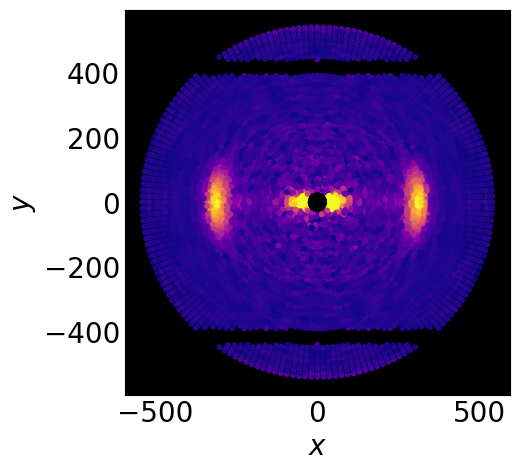

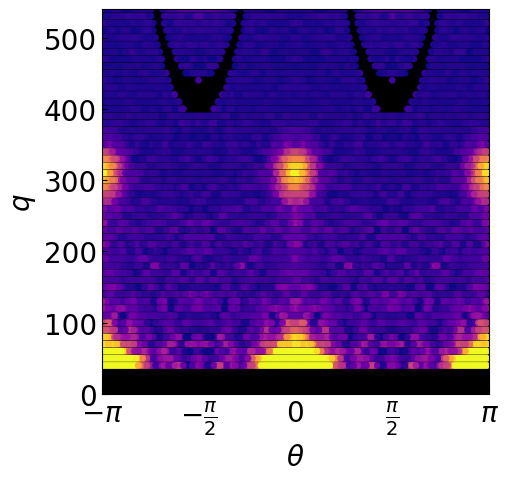

In [12]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
sc = ax.scatter(Qx_eval_flat, Qy_eval_flat, c=I_eval_flat,
                s=10, alpha=1, cmap=cmap, vmin = 0, vmax = I_ref_eval*1.2)
ax.set_xlabel(r'$x$', fontsize=20)
ax.set_ylabel(r'$y$', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.set_aspect(1)
ax.set_facecolor('black')

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
sc = ax.scatter(theta_eval_flat, Q_eval_flat, c=I_eval_flat,
                s=15, alpha=1, cmap=cmap, vmin = 0, vmax = I_ref_eval*1.2)
ax.set_xlabel(r'$\theta$', fontsize=20)
ax.set_ylabel(r'$q$', fontsize=20)
ax.set(xlim=(-np.pi, np.pi), ylim=(0, 540),
       xticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
       xticklabels=[r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'],
       xlabel=r'$\theta$', ylabel=r'$q$')
ax.set_xlabel(r'$\theta$', fontsize=20)
ax.set_ylabel(r'$q$', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.set_facecolor('black')

# Longest time

In [13]:
data_rebinned = data_rebin_list[10]  # Select one rebinned dataset for analysis

# Unpack as regular arrays to avoid masked-array inheritance
x_flat = np.asarray(x.ravel())
y_flat = np.asarray(y.ravel())
I_flat = np.asarray(data_rebinned.data.ravel())  # use .data to strip mask
mask_flat = np.asarray(data_rebinned.mask.ravel()) if np.ma.is_masked(data_rebinned) else np.zeros_like(I_flat, dtype=bool)

# Beam center
cx, cy = beam_center

# Compute Q and theta in rebinned coordinate system
Qx = x_flat - cx
Qy = y_flat - cy
Q_obs_all = np.sqrt(Qx**2 + Qy**2)
theta_obs_all = np.arctan2(Qy, Qx)

# Apply full mask as boolean condition
valid = (~mask_flat) & (I_flat >= 0) & (Q_obs_all > 40) & (Q_obs_all < 540)

# Final filtered arrays (force regular ndarray)
Q_obs = np.asarray(Q_obs_all[valid])
theta_obs = np.asarray(theta_obs_all[valid])
I_obs = np.asarray(I_flat[valid])
delta_I_obs = np.sqrt(I_obs)
delta_I_obs[delta_I_obs == 0] = 1.0

# Duplicate and shift theta
Q_obs_ext = np.concatenate([Q_obs, Q_obs])
theta_obs_ext = np.concatenate([theta_obs, theta_obs + np.pi])
I_obs_ext = np.concatenate([I_obs, I_obs])
delta_I_obs_ext = np.concatenate([delta_I_obs, delta_I_obs])

# Convert polar to Cartesian (observed data points)
Qx_obs = Q_obs_ext * np.cos(theta_obs_ext)
Qy_obs = Q_obs_ext * np.sin(theta_obs_ext)

# Define target location in (theta, Q) space
theta_target = 0.0
Q_target = 300.0

# Compute angular distance properly (wraparound at ±π)
dtheta = np.angle(np.exp(1j * (theta_obs - theta_target)))  # shortest signed angular difference
dQ = Q_obs - Q_target

# Euclidean distance in (theta, Q) space
distance = np.sqrt((dtheta)**2 + (dQ)**2)

# Get indices of 10 closest points
idx_closest = np.argsort(distance)[:15]

# Extract and average intensities
I_ref_obs = np.mean(I_obs[idx_closest])

# Wrap angles to [-π, π] if desired
theta_obs_ext = (theta_obs_ext + np.pi) % (2 * np.pi) - np.pi


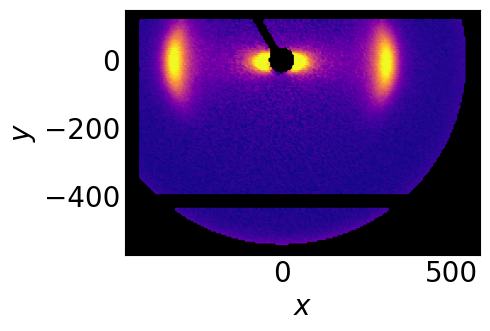

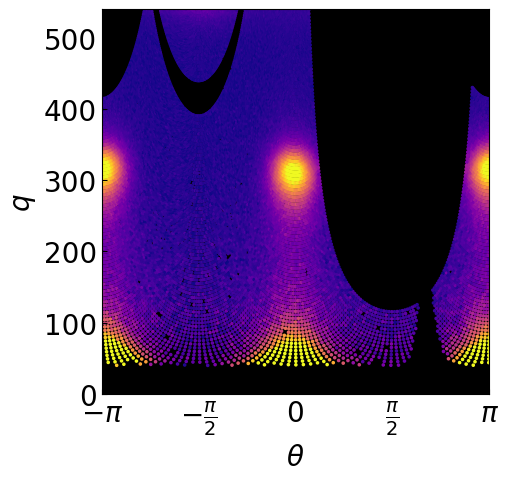

In [14]:
Qx# Convert polar to Cartesian (observed data points)
Qx_obs = Q_obs * np.cos(theta_obs)
Qy_obs = Q_obs * np.sin(theta_obs)

# Plot observed data in (Qx, Qy) space
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

sc = ax.scatter(Qx_obs, Qy_obs, c=I_obs, s=2.5, alpha=1, cmap=cmap, vmin = 0, vmax = I_ref_obs*2)

ax.set_xlabel(r'$x$', fontsize=20)
ax.set_ylabel(r'$y$', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.set_aspect('equal')
ax.set_facecolor('black')
plt.tight_layout()
plt.show()

# Plot observed data in (Qx, Qy) space
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

sc = ax.scatter(theta_obs, Q_obs, c=I_obs, s=2.5, alpha=1, cmap=cmap, vmin = 0, vmax = I_ref_obs*2)
ax.set_xlabel(r'$\theta$', fontsize=20)
ax.set_ylabel(r'$q$', fontsize=20)
ax.set(xlim=(-np.pi, np.pi), ylim=(0, 540),
       xticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
       xticklabels=[r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'],
       xlabel=r'$\theta$', ylabel=r'$q$')
ax.set_xlabel(r'$\theta$', fontsize=20)
ax.set_ylabel(r'$q$', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.set_facecolor('black')



In [15]:
# GPR reconstructed coefficients
spatial_kernel_eval = np.exp(-((Q_eval[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
spatial_kernel_eval = spatial_kernel_eval/np.sum(spatial_kernel_eval, axis=1)  # normalize
A_reconstructed = np.einsum('ij,in->jn', spatial_kernel_eval, A_MAP)
A_plot = A_reconstructed

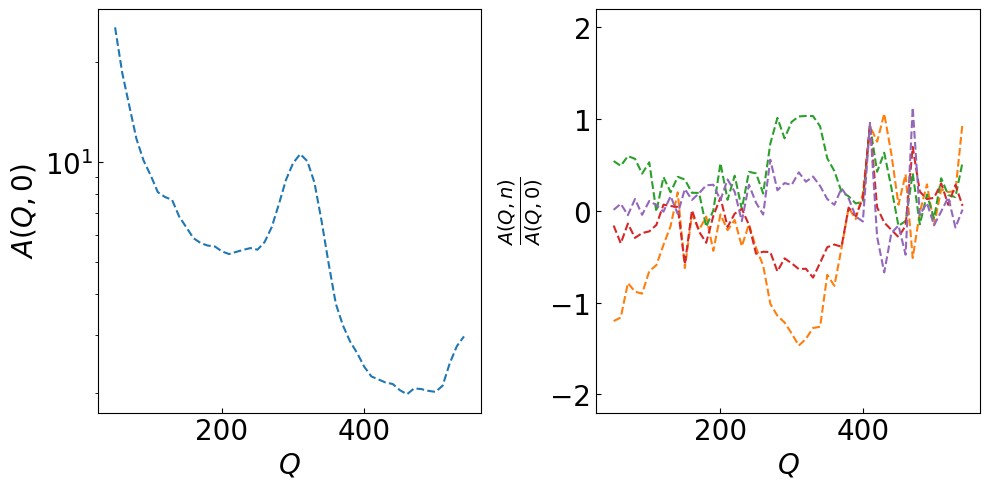

In [16]:
color_list = ['C0', 'C1', 'C2', 'C3', 'C4']
fig = plt.figure(figsize=(10,5))
ax2 = plt.subplot(1, 2, 2)
for i_basis in range(5):
    order = i_basis*2
    if order == 0:
        continue
    y_scale = 1
    # ax2.plot(Q_eval[1:], A_fine[1:, i_basis]*y_scale/A_fine[1:, 0], '-', fillstyle='none', color = color_list[i_basis])
    ax2.plot(Q_eval[1:], A_plot[1:, i_basis]*y_scale/A_plot[1:, 0], '--', fillstyle='none', color = color_list[i_basis])
    # ax2.plot(q_polar_fine[1:], A_grid[1:, i_basis]*y_scale/A_grid[1:, 0], ':', fillstyle='none', color = 'k')

ax2.tick_params(direction='in', labelsize=20)
ax2.set_xlabel(r'$Q$', fontsize=20)
ax2.set_ylabel(r'$\frac{A(Q,n)}{A(Q,0)}$', fontsize=20)
ax2.set_ylim([-2.2, 2.2])
# ax2.set_xlim([0, 10])
# ax2.set_aspect(10/3.5)

plt.tight_layout()

# fig = plt.figure(figsize=(5,5))
ax2 = plt.subplot(1, 2, 1)
y_scale = 1
i_basis = 0
# ax2.plot(q_polar_fine[1:], A_fine[1:, i_basis]*y_scale/A_fine[0, 0], '-', fillstyle='none', color = color_list[i_basis])
ax2.plot(Q_eval[1:], I_radial_eval[1:]*y_scale, '--', fillstyle='none', color = color_list[i_basis])
# ax2.plot(q_polar_fine[1:], A_grid[1:, i_basis]*y_scale/A_fine[0, 0], ':', fillstyle='none', color = 'k')

ax2.tick_params(direction='in', labelsize=20)
ax2.set_xlabel(r'$Q$', fontsize=20)
ax2.set_ylabel(r'$A(Q,0)$', fontsize=20)
# ax2.set_ylim([1e-3, 1])
# ax2.set_xlim([0, 10])
ax2.set_yscale('log')
# ax2.set_aspect(10/1.2)

plt.tight_layout()